# Binární klasifikace obrázků oblečení

Dataset jsou 28x28 obrázky košilí a šatů ve stupních šedi vybrané z tohoto [datasetu](https://www.kaggle.com/datasets/zalando-research/fashionmnist). Příznaky jsou jednotlivé pixely a **label**.

Dataset si připravím a pak použiji SVM, Naivního Bayese a LDA ke klasifikaci. Vygeneruji několik obrázků. Provedu redukci dimenzionality pomocí PCA a LLE a opět provedu binární klasifikaci. Porovnám přesnost pro různý počet dimenzí.

In [1]:
import math
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import metrics, datasets
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding
from tqdm import tqdm
from joblib import Parallel, delayed
%matplotlib inline

# Příprava dat

Data načtu a rozdělím na trénovací, validační a testovací množinu v poměru 6:2:2. Jelikož se jedná o obrázky, kde příznaky odpovídají pixelům, nebude nutná rozsáhlá příprava dat.

In [2]:
data = pd.read_csv("train.csv")
display(data.head())
data.info()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,95,132,90,0,0,0
2,1,0,0,0,0,0,0,3,0,23,...,94,68,44,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,57,0,0,0,26,71,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,2,0,6,156,149,78,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 9.0 MB


In [3]:
Xdata = data.drop("label", axis=1)
Ydata = data["label"]

random_seed = 333

Xtrain, Xrest, Ytrain, Yrest = train_test_split(Xdata, Ydata, test_size=0.4, random_state=random_seed)
Xval, Xtest, Yval, Ytest = train_test_split(Xrest, Yrest, test_size=0.5, random_state=random_seed)

display(Xtrain.head())
display(Xtrain.info())
display(Xtrain.describe())
display(Xtrain.nunique())
display(Ytrain.value_counts())

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
1300,0,0,0,0,0,0,0,1,0,6,...,0,0,4,0,47,226,222,98,0,0
150,0,0,0,0,0,1,1,0,0,0,...,36,41,15,0,0,0,0,0,0,0
414,0,0,0,0,0,0,0,0,0,73,...,181,144,42,0,0,0,0,0,0,0
533,0,0,0,0,0,0,0,0,0,0,...,82,0,2,0,0,0,0,0,0,0
816,0,0,0,0,0,0,0,0,0,0,...,154,143,124,20,0,0,1,0,0,0


<class 'pandas.core.frame.DataFrame'>
Index: 900 entries, 1300 to 973
Columns: 784 entries, pixel1 to pixel784
dtypes: int64(784)
memory usage: 5.4 MB


None

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,900.0,900.0,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,...,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000
mean,0.0,0.0,0.005556,0.013333,0.124444,0.202222,0.722222,1.680000,3.723333,11.676667,...,44.174444,24.682222,12.277778,25.876667,36.883333,26.356667,10.186667,1.671111,0.185556,0.006667
std,0.0,0.0,0.110476,0.169538,2.058127,2.369907,7.198949,13.230221,18.346016,30.125524,...,59.128314,45.633364,31.423770,53.010664,65.316912,53.376770,31.198040,13.561242,3.965930,0.200000
min,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,83.000000,31.000000,1.000000,14.250000,55.500000,13.000000,0.000000,0.000000,0.000000,0.000000
max,0.0,0.0,3.000000,3.000000,53.000000,52.000000,136.000000,216.000000,183.000000,192.000000,...,240.000000,227.000000,231.000000,255.000000,249.000000,226.000000,231.000000,171.000000,97.000000,6.000000


pixel1        1
pixel2        1
pixel3        3
pixel4        4
pixel5        6
           ... 
pixel780    151
pixel781     94
pixel782     21
pixel783      4
pixel784      2
Length: 784, dtype: int64

label
0    457
1    443
Name: count, dtype: int64

Jedná se o binární klasifikaci, vysvětlovaná proměnná nabývá hodnot 0 a 1. Dataset je vyvážený, je v něm 457x hodnota 0 a 443x hodnota 1, proto budu k hodnocení modelů používat přesnost. Zároveň si můžeme všimnout, že pixely 1 a 2 mají všude jen hodnotu 0 - jsou černé na všech obrázcích a nejsou vlastně potřeba.

Podívejme se, jak obrázky vypadají.

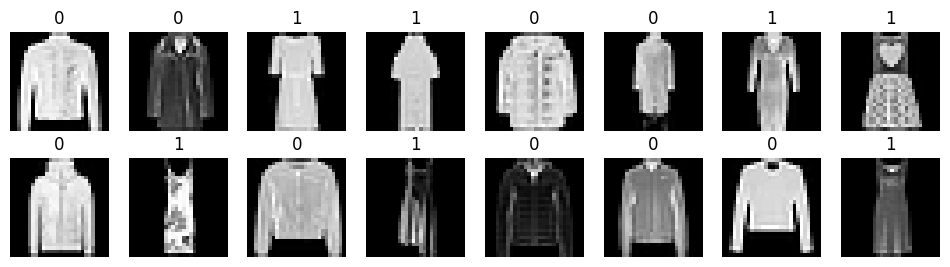

In [4]:
fig, axes = plt.subplots(2, 8, figsize=(12,3))

for i, ax in enumerate(axes.flatten()):
    ax.axis(False)
    ax.imshow(np.array(Xtrain.iloc[i]).reshape(28, 28), cmap="gray")
    ax.set_title(f"{Ytrain.iloc[i]}")

Obrázky s *label* rovno 0 jsou košile, obrázky s *label* rovno 1 jsou šaty.

Data ještě znormalizuji. Ovšem nepoužiju klasickou min-max normalizaci nebo standardizaci po příznacích, protože by tak pixely, které jsou všude tmavé, a pixely, které jsou všude světlé, nabývaly stejných hodnot. Místo toho použiju min-max normalizaci přes celý dataset, což znamená, že všechny hodnoty vydělím 255 - černá bude 0, bílá bude 1, různé odstíny šedé budou mezi 0 a 1.

In [5]:
Xtrain.max().max()

np.int64(255)

In [6]:
Xtrain_normal = Xtrain.copy()
Xval_normal = Xval.copy()
Xtest_normal = Xtest.copy()
Xtrain_normal /= 255.0
Xval_normal /= 255.0
Xtest_normal /= 255.0

# SVM

SVM je vhodné, když jsou data lineárně separabilní. Používá jádrové funkce, díky čemuž může dobře fungovat i na data, která v prostoru původních příznaků lineárně separabilní nejsou. Trénování je ale poměrně výpočetně náročné.

Postupně vyzkouším všechna jádra: linear, poly, rbf. Ladit budu regularizační hyperparametr C.

In [7]:
def train_SVM(Xtr, Ytr, Xv, Yv, param_grid):
    param_comb = ParameterGrid(param_grid)

    val_acc = []
    for params in param_comb:
        clf = SVC(**params)
        clf.fit(Xtr, Ytr)
        val_acc.append(metrics.accuracy_score(Yv, clf.predict(Xv)))
    best_params = param_comb[np.argmax(val_acc)]
    return (best_params, np.max(val_acc))


param_grid = {
    "C": np.logspace(-3, 3, 30),
    "kernel": ["linear"],
}

best_params, val_acc = train_SVM(Xtrain_normal, Ytrain, Xval_normal, Yval, param_grid)
clfSVM = SVC(**best_params)
clfSVM.fit(Xtrain_normal, Ytrain)
print("SVM - linear kernel")
print(best_params)
print(f"Train accuracy: {metrics.accuracy_score(Ytrain, clfSVM.predict(Xtrain_normal)):.4f}")
print(f"Validation accuracy: {metrics.accuracy_score(Yval, clfSVM.predict(Xval_normal)):.4f}")

SVM - linear kernel
{'kernel': 'linear', 'C': np.float64(0.02807216203941177)}
Train accuracy: 0.9689
Validation accuracy: 0.9433


Pro lineární jádro vychází přesnost na validační množině 94.33 %. Hodnota C je 0.028.

In [8]:
param_grid = {
    "C": np.logspace(-3, 3, 30),
    "kernel": ["poly"],
}

best_params, val_acc = train_SVM(Xtrain_normal, Ytrain, Xval_normal, Yval, param_grid)
clfSVM = SVC(**best_params)
clfSVM.fit(Xtrain_normal, Ytrain)
print("SVM - poly kernel")
print(best_params)
print(f"Train accuracy: {metrics.accuracy_score(Ytrain, clfSVM.predict(Xtrain_normal)):.4f}")
print(f"Validation accuracy: {metrics.accuracy_score(Yval, clfSVM.predict(Xval_normal)):.4f}")

SVM - poly kernel
{'kernel': 'poly', 'C': np.float64(5.298316906283707)}
Train accuracy: 0.9833
Validation accuracy: 0.9433


U polynomiálního jádra vychází stejná přesnost na validační množině jako u lineárního - 94.33 %. C je 5.298.

In [9]:
param_grid = {
    "C": np.logspace(-3, 3, 30),
    "kernel": ["rbf"],
}

best_params, val_acc = train_SVM(Xtrain_normal, Ytrain, Xval_normal, Yval, param_grid)
clfSVM = SVC(**best_params,)
clfSVM.fit(Xtrain_normal, Ytrain)
print("SVM - rbf kernel")
print(best_params)
print(f"Train accuracy: {metrics.accuracy_score(Ytrain, clfSVM.predict(Xtrain_normal)):.4f}")
print(f"Validation accuracy: {metrics.accuracy_score(Yval, clfSVM.predict(Xval_normal)):.4f}")

SVM - rbf kernel
{'kernel': 'rbf', 'C': np.float64(13.738237958832638)}
Train accuracy: 0.9978
Validation accuracy: 0.9567


RBF jádro je na tom nejlépe, má validační přesnost 95.67 %. Hodnota hyperparametru C je 13.738.

# Naivní Bayes

Naivní Bayes naivně předpokládá nezávislost příznaků za podmínky vysvětlované proměnné. Díky tomu, že se na každý příznak dívá zvlášť, nejsou k trénování potřeba obrovské datasety. Navíc není tak výpočetně náročný. Pixely podmíněně nezávislé rozhodně nejsou, ale třeba bude dávat dobré výsledky.

Příznaky nejsou binární ani nereprezentují počty, proto nepoužiju BernoulliNB ani MultinomialNB, ale GaussianNB.

In [10]:
clfNB = GaussianNB()
clfNB.fit(Xtrain_normal, Ytrain)
print("Naive Bayes")
print(f"Train accuracy: {metrics.accuracy_score(Ytrain, clfNB.predict(Xtrain_normal)):.4f}")
print(f"Validation accuracy: {metrics.accuracy_score(Yval, clfNB.predict(Xval_normal)):.4f}")

Naive Bayes
Train accuracy: 0.8744
Validation accuracy: 0.8600


Naivní Bayes má přesnost na validační množině 86 %, to je horší než SVM.

# LDA

Lineární diskriminační analýza předpokládá, že za podmínky pro každou třídu vysvětlované proměnné mají příznaky vícerozměrné normální rozdělení s různými vektory středních hodnot, ale se stejnou varianční maticí. To asi pro košile a šaty platit nebude, ale podívejme se, jaké dává výsledky.

In [11]:
clfLDA = LinearDiscriminantAnalysis(store_covariance=True)
clfLDA.fit(Xtrain_normal, Ytrain)
print("LDA")
print(f"Train accuracy: {metrics.accuracy_score(Ytrain, clfLDA.predict(Xtrain_normal)):.4f}")
print(f"Validation accuracy: {metrics.accuracy_score(Yval, clfLDA.predict(Xval_normal)):.4f}")

LDA
Train accuracy: 1.0000
Validation accuracy: 0.8067


LDA má validační přesnost 80.67 %, to je zatím nejhorší.

# Generování obrázků

LDA odhaduje výše zmíněné parametry (vektory středních hodnot, varianční matici) a to nám umožňuje generovat obrázky. Zkusme jich pár vygenerovat.

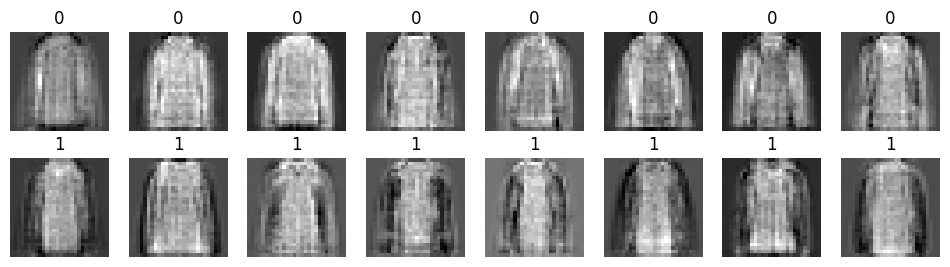

In [12]:
shirts_generated = np.random.multivariate_normal(clfLDA.means_[0], clfLDA.covariance_, 8)
dresses_generated = np.random.multivariate_normal(clfLDA.means_[1], clfLDA.covariance_, 8)

fig, axes = plt.subplots(2, 8, figsize=(12,3))

for i, ax in enumerate(axes[0]):
    ax.axis(False)
    ax.imshow(255.0 * shirts_generated[i].reshape(28, 28), cmap="gray")
    ax.set_title(f"{0}")

for i, ax in enumerate(axes[1]):
    ax.axis(False)
    ax.imshow(255.0 * dresses_generated[i].reshape(28, 28), cmap="gray")
    ax.set_title(f"{1}")


Obrázky připomínají oblečení, ale moc nevidím rozdíl mezi kategoriemi (šaty a košile).

Podívejme se i na obrázky generované kvadratickou diskriminační analýzou, ta nepředpokládá stejnou varianční matici pro všechny třídy. Proto by mohl mezi obrázky být větší rozdíl.

In [13]:
warnings.simplefilter("ignore", UserWarning)

clfQDA = QuadraticDiscriminantAnalysis(store_covariance=True)
clfQDA.fit(Xtrain_normal, Ytrain)
print("QDA")
print(f"Train accuracy: {metrics.accuracy_score(Ytrain, clfLDA.predict(Xtrain_normal)):.4f}")
print(f"Validation accuracy: {metrics.accuracy_score(Yval, clfLDA.predict(Xval_normal)):.4f}")

QDA
Train accuracy: 1.0000
Validation accuracy: 0.8067


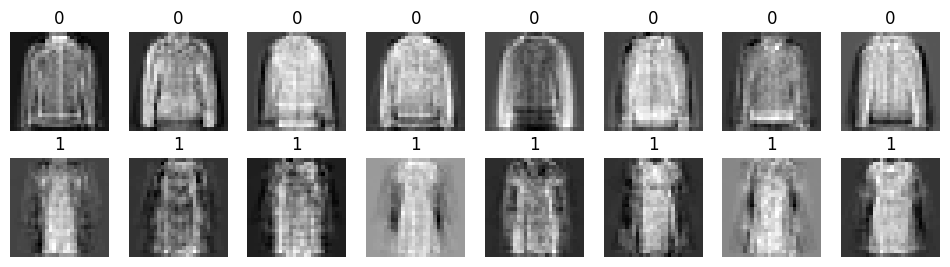

In [14]:
shirts_generated = np.random.multivariate_normal(clfQDA.means_[0], clfQDA.covariance_[0], 8)
dresses_generated = np.random.multivariate_normal(clfQDA.means_[1], clfQDA.covariance_[1], 8)

fig, axes = plt.subplots(2, 8, figsize=(12,3))

for i, ax in enumerate(axes[0]):
    ax.axis(False)
    ax.imshow(255.0 * shirts_generated[i].reshape(28, 28), cmap="gray")
    ax.set_title(f"{0}")

for i, ax in enumerate(axes[1]):
    ax.axis(False)
    ax.imshow(255.0 * dresses_generated[i].reshape(28, 28), cmap="gray")
    ax.set_title(f"{1}")

Tady už je rozdíl mezi košilemi a šaty docela znatelný.

# Redukce dimenzionality

Obrázky mají velikost 28 x 28, takže příznaků je 784. Ale viděli jsme, že první dva pixely jsou vždycky černé, tedy nejsou vůbec potřeba. Vyzkouším redukovat dimenzi pomocí PCA a LLE.

## PCA

PCA hledá takový podprostor prostoru příznaků zadané dimenze, že projekce bodů na něj má co nejmenší kvadratickou chybu (neboli projektované body mají největší rozptyl).

Pro každou dimenzi natrénuji SVM, NB a LDA a podíváme se, jestli se validační přesnost modelů zlepší nebo zhorší. Kvůli výpočetní náročnosti nebudu zkoušet všechny dimenze menší než 784, ale půjdu po třech (1, 4, 7,...). Ze stejného důvodu budu u SVM zkoušet jen rbf jádro.

In [15]:
def train_all_with_PCA(dims, Xtr, Ytr, Xv, Yv, param_gridSVM):
    # PCA
    pca = PCA(n_components=dims)
    Xtr_pca = pca.fit_transform(Xtr)
    Xv_pca = pca.transform(Xv)
    
    # SVM
    best_paramsSVM, val_accSVM = train_SVM(Xtr_pca, Ytr, Xv_pca, Yv, param_gridSVM)

    # Naive Bayes
    clfNB = GaussianNB()
    clfNB.fit(Xtr_pca, Ytr)
    val_accNB = metrics.accuracy_score(Yv, clfNB.predict(Xv_pca))

    # LDA
    clfLDA = LinearDiscriminantAnalysis()
    clfLDA.fit(Xtr_pca, Ytr)
    val_accLDA = metrics.accuracy_score(Yv, clfLDA.predict(Xv_pca))

    return (best_paramsSVM, val_accSVM, val_accNB, val_accLDA)
    

def process_dim_PCA(dim, Xtr, Ytr, Xv, Yv, param_gridSVM):
    paramsSVM, val_accSVM, val_accNB, val_accLDA = train_all_with_PCA(dim, Xtrain_normal, Ytrain, Xval_normal, Yval, param_gridSVM)
    return (dim, paramsSVM, val_accSVM, val_accNB, val_accLDA)


param_gridSVM = {
    "C": np.logspace(-3, 3, 30),
    "kernel": ["rbf"],
}

results_PCA = Parallel(n_jobs=-1)(
    delayed(process_dim_PCA)(dim, Xtrain_normal, Ytrain, Xval_normal, Yval, param_gridSVM)
    for dim in tqdm(range(1, Xtrain_normal.shape[1], 3), position=0, leave=True)
)

100%|███████████████████████████████████████████████████████████████████████| 261/261 [03:30<00:00,  1.24it/s]


In [16]:
bestSVM_PCA = {"val_acc": 0, "params": None, "dim": None}
bestNB_PCA = {"val_acc": 0, "dim": None}
bestLDA_PCA = {"val_acc": 0, "dim": None}

for (dim, paramsSVM, val_accSVM, val_accNB, val_accLDA) in results_PCA:
    if val_accSVM > bestSVM_PCA["val_acc"]:
        bestSVM_PCA["val_acc"] = val_accSVM
        bestSVM_PCA["params"] = paramsSVM
        bestSVM_PCA["dim"] = dim

    if val_accNB > bestNB_PCA["val_acc"]:
        bestNB_PCA["val_acc"] = val_accNB
        bestNB_PCA["dim"] = dim

    if val_accLDA > bestLDA_PCA["val_acc"]:
        bestLDA_PCA["val_acc"] = val_accLDA
        bestLDA_PCA["dim"] = dim

print("SVM")
print(bestSVM_PCA)
print("Naive Bayes")
print(bestNB_PCA)
print("LDA")
print(bestLDA_PCA)

SVM
{'val_acc': np.float64(0.95), 'params': {'kernel': 'rbf', 'C': np.float64(57.361525104486816)}, 'dim': 61}
Naive Bayes
{'val_acc': 0.91, 'dim': 76}
LDA
{'val_acc': 0.9433333333333334, 'dim': 88}


Validační přesnost SVM se mírně zhoršila z 95.67 % na 95 %, ale stačí k tomu jen 61 dimenzí. Přesnost na validační množině naivního Bayese se zlepšila z 86 % na 91 %. LDA se zlepšilo z 80.67 % na 94.33 %, to je opravdu velký skok a stačí k tomu jen 88 dimenzí.

Podívejme se, jaké přesnosti modely dosahovaly na nižších, středních a vysokých dimenzích.

In [17]:
dimensions = [x[0] for x in results_PCA]
svm_acc = [x[2] for x in results_PCA]
nb_acc = [x[3] for x in results_PCA]
lda_acc = [x[4] for x in results_PCA]

accuracy_PCA = pd.DataFrame({"Dimenze": dimensions, "SVM": svm_acc, "Naive Bayes": nb_acc, "LDA": lda_acc})
accuracy_PCA = accuracy_PCA.set_index("Dimenze")

In [18]:
accuracy_PCA.head(10)

,SVM,Naive Bayes,LDA
Dimenze,,,
1,0.853333,0.846667,0.850000
4,0.883333,0.863333,0.876667
7,0.926667,0.883333,0.903333
10,0.926667,0.896667,0.923333
13,0.936667,0.906667,0.930000
16,0.936667,0.890000,0.930000
19,0.936667,0.886667,0.936667
22,0.936667,0.883333,0.930000
25,0.940000,0.873333,0.920000


I když je dimenze jen 1, všechny modely mají validační přesnost okolo 85 %, to je slušné. S dimenzí 13 mají všechny tři modely validační přesnost nad 90 %. Zároveň vidíme, že ne vždy znamená větší dimenze větší přesnost.

In [19]:
accuracy_PCA.iloc[125:135]

,SVM,Naive Bayes,LDA
Dimenze,,,
376,0.946667,0.743333,0.910000
379,0.946667,0.733333,0.906667
382,0.943333,0.716667,0.906667
385,0.946667,0.726667,0.900000
388,0.946667,0.716667,0.896667
391,0.946667,0.716667,0.906667
394,0.946667,0.706667,0.896667
397,0.946667,0.683333,0.893333
400,0.946667,0.690000,0.896667


Okolo dimenze 390 se přesnost SVM drží na 94.67 %, přesnost LDA okolo 90 %, ale přesnost Naivního Bayese se zhoršila na 70 %.

In [20]:
accuracy_PCA.tail(10)

,SVM,Naive Bayes,LDA
Dimenze,,,
754,0.946667,0.536667,0.790000
757,0.946667,0.536667,0.786667
760,0.946667,0.536667,0.786667
763,0.946667,0.536667,0.786667
766,0.946667,0.536667,0.786667
769,0.946667,0.536667,0.786667
772,0.946667,0.536667,0.786667
775,0.946667,0.536667,0.786667
778,0.946667,0.536667,0.786667


PCA s vyšší dimenzí opravdu ublížilo Naivnímu Bayesovi a LDA. SVM se drží na 94.67 %.

## LLE

LLE se zaměřuje na lokální vlastnosti dat. Zachovává informaci, jak body z trénovací množiny závisí na svých sousedech.

Budu zkoušet dimenze po deseti (1, 11, 21,...) a počet sousedů 2, 5, 10, 20, 50.

In [21]:
def train_all_with_LLE(dims, neighbors, Xtr, Ytr, Xv, Yv, param_gridSVM):
    # LLE
    lle = LocallyLinearEmbedding(n_components=dims, n_neighbors=neighbors)
    Xtr_lle = lle.fit_transform(Xtr)
    Xv_lle = lle.transform(Xv)
    
    # SVM
    best_paramsSVM, val_accSVM = train_SVM(Xtr_lle, Ytr, Xv_lle, Yv, param_gridSVM)

    # Naive Bayes
    clfNB = GaussianNB()
    clfNB.fit(Xtr_lle, Ytr)
    val_accNB = metrics.accuracy_score(Yv, clfNB.predict(Xv_lle))

    # LDA
    clfLDA = LinearDiscriminantAnalysis()
    clfLDA.fit(Xtr_lle, Ytr)
    val_accLDA = metrics.accuracy_score(Yv, clfLDA.predict(Xv_lle))

    return (best_paramsSVM, val_accSVM, val_accNB, val_accLDA)


def process_dim_neigh_LLE(dim, neigh, Xtr, Ytr, Xv, Yv, param_gridSVM):
    best_paramsSVM, val_accSVM, val_accNB, val_accLDA = train_all_with_LLE(dim, neigh, Xtr, Ytr, Xv, Yv, param_gridSVM)
    return (dim, neigh, best_paramsSVM, val_accSVM, val_accNB, val_accLDA)


param_gridSVM = {
    "C": np.logspace(-3, 3, 30),
    "kernel": ["rbf"],
}
dimensions = range(1, Xtrain_normal.shape[1], 10)
neighbors = [2, 5, 10, 20, 50]
total_iters = len(dimensions) * len(neighbors)

results_LLE = Parallel(n_jobs=-1)(
    delayed(process_dim_neigh_LLE)(dim, neigh, Xtrain_normal, Ytrain, Xval_normal, Yval, param_gridSVM)
    for dim, neigh in tqdm(itertools.product(dimensions, neighbors), total=total_iters, position=0, leave=True)
)

100%|███████████████████████████████████████████████████████████████████████| 395/395 [11:05<00:00,  1.69s/it]


In [22]:
bestSVM_LLE = {"val_acc": 0, "params": None, "dim": None, "neigh": None}
bestNB_LLE = {"val_acc": 0, "dim": None, "neigh": None}
bestLDA_LLE = {"val_acc": 0, "dim": None, "neigh": None}

for (dim, neigh, paramsSVM, val_accSVM, val_accNB, val_accLDA) in results_LLE:
    if val_accSVM > bestSVM_LLE["val_acc"]:
        bestSVM_LLE["val_acc"] = val_accSVM
        bestSVM_LLE["params"] = paramsSVM
        bestSVM_LLE["dim"] = dim
        bestSVM_LLE["neigh"] = neigh

    if val_accNB > bestNB_LLE["val_acc"]:
        bestNB_LLE["val_acc"] = val_accNB
        bestNB_LLE["dim"] = dim
        bestNB_LLE["neigh"] = neigh

    if val_accLDA > bestLDA_LLE["val_acc"]:
        bestLDA_LLE["val_acc"] = val_accLDA
        bestLDA_LLE["dim"] = dim
        bestLDA_LLE["neigh"] = neigh

print("SVM")
print(bestSVM_LLE)
print("Naive Bayes")
print(bestNB_LLE)
print("LDA")
print(bestLDA_LLE)

SVM
{'val_acc': np.float64(0.9633333333333334), 'params': {'kernel': 'rbf', 'C': np.float64(1.2689610031679222)}, 'dim': 141, 'neigh': 10}
Naive Bayes
{'val_acc': 0.91, 'dim': 21, 'neigh': 50}
LDA
{'val_acc': 0.9566666666666667, 'dim': 311, 'neigh': 10}


SVM a LDA po použití LLE dosahují zatím největší validační přesnosti. Naivní Bayes je na tom stejně jako s PCA. SVM má validační přesnost 96.33 % s dimenzí 141 a 10 sousedy. Naivní Bayes má validační přesnost 91 % s dimenzí 21 a 50 sousedy a LDA má validační přesnost 95.67 % s dimenzí 311 a 10 sousedy.

Podívejme se, jak se přesnost modelů liší v závislosti na dimenzi a počtu sousedů.

In [23]:
dimensions = [x[0] for x in results_LLE]
neighbors = [x[1] for x in results_LLE]
svm_acc = [x[3] for x in results_LLE]
nb_acc = [x[4] for x in results_LLE]
lda_acc = [x[5] for x in results_LLE]

accuracy_LLE = pd.DataFrame({"Dimension": dimensions, "Neighbors": neighbors, "SVM": svm_acc, "Naive Bayes": nb_acc, "LDA": lda_acc})
accuracy_LLE = accuracy_LLE.set_index(["Dimension", "Neighbors"], verify_integrity=True)

In [24]:
accuracy_LLE.head(20)

SVM  Naive Bayes       LDA
Dimension Neighbors                                 
1         2          0.756667     0.523333  0.670000
          5          0.866667     0.870000  0.870000
          10         0.883333     0.870000  0.873333
          20         0.886667     0.886667  0.886667
          50         0.880000     0.870000  0.876667
11        2          0.926667     0.696667  0.683333
          5          0.910000     0.860000  0.883333
          10         0.946667     0.883333  0.893333
          20         0.936667     0.870000  0.900000
          50         0.940000     0.890000  0.896667
21        2          0.920000     0.700000  0.890000
          5          0.943333     0.870000  0.896667
          10         0.950000     0.873333  0.910000
          20         0.946667     0.883333  0.910000
          50         0.953333     0.910000  0.946667
31        2          0.930000     0.823333  0.920000
          5          0.950000     0.873333  0.913333
          10         0.956667     0.876667  0.926667
          20         0.950000     0.873333  0.916667
          50         0.960000     0.896667  0.953333

Na malých dimenzích je pro NB a LDA lepší větší počet sousedů. Pro SVM většinou taky, ale pro dimenzi 1 a 11 je lepší jen 10 sousedů. Přesnost všech modelů se pohybuje okolo 87-95 %.

In [25]:
accuracy_LLE.iloc[180:200]

SVM  Naive Bayes       LDA
Dimension Neighbors                                 
361       2          0.946667     0.870000  0.936667
          5          0.960000     0.856667  0.953333
          10         0.963333     0.886667  0.956667
          20         0.953333     0.876667  0.936667
          50         0.943333     0.896667  0.933333
371       2          0.943333     0.870000  0.936667
          5          0.956667     0.856667  0.950000
          10         0.960000     0.886667  0.953333
          20         0.953333     0.873333  0.936667
          50         0.943333     0.896667  0.933333
381       2          0.940000     0.870000  0.933333
          5          0.960000     0.856667  0.953333
          10         0.960000     0.886667  0.953333
          20         0.956667     0.880000  0.936667
          50         0.943333     0.896667  0.936667
391       2          0.950000     0.870000  0.933333
          5          0.956667     0.856667  0.953333
          10         0.960000     0.890000  0.953333
          20         0.956667     0.880000  0.936667
          50         0.943333     0.896667  0.933333

Na dimenzích okolo 370 se přesnost SVM a LDA pohybuje okolo 95 % pro všechny možnosti sousedů. Přesnost NB je největší pro 50 sousedů a dosahuje 89.67 %.

In [26]:
accuracy_LLE.tail(20)

SVM  Naive Bayes       LDA
Dimension Neighbors                                 
751       2          0.936667     0.880000  0.933333
          5          0.950000     0.863333  0.946667
          10         0.956667     0.880000  0.956667
          20         0.946667     0.890000  0.936667
          50         0.943333     0.890000  0.940000
761       2          0.940000     0.883333  0.933333
          5          0.946667     0.863333  0.946667
          10         0.956667     0.880000  0.953333
          20         0.953333     0.890000  0.933333
          50         0.946667     0.893333  0.940000
771       2          0.940000     0.880000  0.933333
          5          0.950000     0.856667  0.950000
          10         0.956667     0.880000  0.953333
          20         0.953333     0.890000  0.936667
          50         0.940000     0.893333  0.940000
781       2          0.940000     0.883333  0.936667
          5          0.950000     0.856667  0.946667
          10         0.956667     0.883333  0.953333
          20         0.953333     0.886667  0.940000
          50         0.943333     0.886667  0.936667

Na dimenzích okolo 760 je přesnost všech modelů podobná jako u dimenzí okolo 370.

Při použití LLE nedošlo u vyšších dimenzí ke zhoršení přesnosti Naivního Bayese a LDA jako u PCA.

# Finální model

Nejvyšší přesnost na validační množině byla 96.33 %. Dosáhlo jí SVM s LLE s následujícími hyperparametry, proto to bude můj finální model.

Hyperparametry LLE:

- 141 dimenzí
- 10 sousedů

Hyperparametry SVM:

- kernel: rbf
- C: 1.269

Na testovací množině, kterou model dosud neviděl, odhadnu přesnost na nových datech. Poté udělám predikci pro data z `evaluate.csv`.

In [27]:
params = {'kernel': 'rbf', 'C': np.float64(1.2689610031679222), 'dim': 141, 'neigh': 10}

lle = LocallyLinearEmbedding(n_components=params["dim"], n_neighbors=params["neigh"])
Xtrain_lle = lle.fit_transform(Xtrain_normal)
Xval_lle = lle.transform(Xval_normal)
Xtest_lle = lle.transform(Xtest_normal)

clf = SVC(kernel=params["kernel"], C=params["C"])
clf.fit(Xtrain_lle, Ytrain)
print(f"Odhad přesnosti na nových datech: {metrics.accuracy_score(Ytest, clf.predict(Xtest_lle)):.4f}")

Odhad přesnosti na nových datech: 0.9500


In [28]:
Xeval = pd.read_csv("evaluate.csv")
Xeval = Xeval.set_index("ID")
Xeval_normal = Xeval.copy()
Xeval_normal /= 255.0
Xeval_lle = lle.transform(Xeval_normal)

Ypred = clf.predict(Xeval_lle)
results_df = pd.DataFrame({"label": Ypred}, index=Xeval_normal.index)
results_df.to_csv("results.csv")
results_df

,label
ID,
0,1
1,0
2,0
3,0
4,0
...,...
1495,1
1496,0
1497,0


# Závěr

Použil jsem SVM, Naivního Bayese a LDA ke klasifikaci obrázků oblečení. Některé obrázky jsem zkusil i vygenerovat. Vyzkoušel jsem si redukci dimenzionality pomocí PCA a LLE a zkoumal, jaký vliv měla na zmíněné modely.